# Creating ToF Waterfall plots

Just execute everything line by line. There is a note, where things can be changed

In [13]:
# Stephan Kuschel, 2019
import matplotlib.pyplot as plt
%matplotlib notebook
import karabo_data
from tqdm import tqdm_notebook as tqdm
import numpy as np
import functools
from collections.abc import Iterable
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm


def addcolorbar(ax, im, pos='right', size='5%', pad=0.05, orientation='vertical',
                stub=False, max_ticks=None, label=None):
    '''
    add a colorbar to a matplotlib image.
    
    ax -- the axis object the image is drawn in
    im -- the image (return value of ax.imshow(...))
    
    When changed, please update:
    https://gist.github.com/skuschel/85f0645bd6e37509164510290435a85a
    
    Stephan Kuschel, 2018
    '''
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(pos, size=size, pad=pad)
    if stub:
        cax.set_visible(False)
        return cax
    
    cb = plt.colorbar(im, cax=cax, orientation=orientation)
    if max_ticks is not None:
        from matplotlib import ticker
        tick_locator = ticker.MaxNLocator(nbins=max_ticks)
        cb.locator = tick_locator
        cb.update_ticks()
    if label is not None:
        cb.set_label(label)
    return cax

def multiruns(f):
    '''
    decorator to yield multiple runs
    '''
    @functools.wraps(f)
    def ret(runn, **kwargs):
        if isinstance(runn, int):
            yield f(runn, **kwargs)
        elif isinstance(runn, Iterable):
            for run in runn:
                yield f(run, **kwargs)
    return ret

In [3]:
@multiruns
@functools.lru_cache()
def gettof(runn):
    # delay is the scanned variable
    run = karabo_data.RunDirectory('/gpfs/exfel/exp/SQS/201921/p002430/raw/r{:04n}'.format(runn))
    tof = np.asarray(run.get_array('SQS_DIGITIZER_UTC1/ADC/1:network', 'digitizers.channel_1_A.raw.samples'))
    #print('shape of image stream: {}'.format(imges.shape))
    #imgyield = np.mean(imges, axis=(1,2))
    #print(imgyield.shape)
    #brightidx = np.argsort(imgyield)[::-1], images
    tof_grounded = tof[:, 262000:290000] - tof[:, :10000].mean()
    return np.array(tof_grounded)

@multiruns
@functools.lru_cache()
def getdelay(runn):
    run = karabo_data.RunDirectory('/gpfs/exfel/exp/SQS/201921/p002430/raw/r{:04n}'.format(runn))
    delay = np.asarray(run.get_array('SQS_NQS_CRSC/TSYS/PARKER_TRIGGER', 'actualDelay.value'))
    return delay
getdelay.name = 'parker delay'

@multiruns
@functools.lru_cache()
def getpulseE(runn):
    run = karabo_data.RunDirectory('/gpfs/exfel/exp/SQS/201921/p002430/raw/r{:04n}'.format(runn))
    ret = np.asarray(run.get_array('SA3_XTD10_XGM/XGM/DOOCS:output','data.intensityTD')[:,120])
    return ret


@multiruns
@functools.lru_cache()
def gettofandE(runn):
    run = karabo_data.RunDirectory('/gpfs/exfel/exp/SQS/201921/p002430/raw/r{:04n}'.format(runn))
    E = np.asarray(run.get_array('SA3_XTD10_XGM/XGM/DOOCS:output','data.intensityTD')[:,120])
    tof = np.asarray(run.get_array('SQS_DIGITIZER_UTC1/ADC/1:network', 'digitizers.channel_1_A.raw.samples'))
    tof_grounded = tof[:, 262000:290000] - tof[:, :10000].mean()
    return np.array([tof_grounded, E])

In [6]:
def valoccurances(vals, minocc=10):
    scanparamters = np.unique(vals)
    ret = [d for d in scanparamters if np.sum(vals==d) >= minocc]
    return np.asarray(ret)

def findvals(runn, dataf, minocc=10):
    datas = dataf(runn)
    for data in datas:
        yield valoccurances(data, minocc=minocc)
    

def grouped_data(runn, dataf=gettof, groupbyf=getdelay):
    for data, scanvals, scanposs in zip(dataf(runn), findvals(runn, groupbyf), groupbyf(runn)):
        datagroups = [[scanval, data[scanposs==scanval]] for scanval in scanvals]
        yield from datagroups

def plotavg(runn, waterfall=0, nametemplate='{val:.1f}', groupbyf=getdelay, alpha=1):
    fig, ax = plt.subplots()
    datagen = grouped_data(runn, groupbyf=groupbyf)
    name_list = []
    pos_list = []
    for i, (val, data) in enumerate(datagen):
        tof = data
        ax.plot(-np.mean(tof, axis=0)-i*waterfall, label=val, alpha=alpha)
        name_list.append(nametemplate.format(val=val, i=i))
        pos_list.append(-i*waterfall)
    #ax.set_yscale('log')
    if hasattr(groupbyf, 'name'):
        ax.set_ylabel(groupbyf.name)
    #fig.set_size_inches((16,10))
    #ax.legend()
    #ax2 = ax.twinx()
    ax.yaxis.set_major_locator(ticker.FixedLocator((pos_list)))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter((name_list)))
    #ax.set_ylim([0, 100000])
    ax.set_xlim([3000, 25000])
    return fig, ax


#ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
#fig

# Start editing here

The next cell defines the plot. `r` is a list with runs to include. In each run the software groups by the parker valve delay.
The first time on each execution the data is retrieved and saved, so running the next cell a second time will be much faster. This is for changing the plot to your liking.

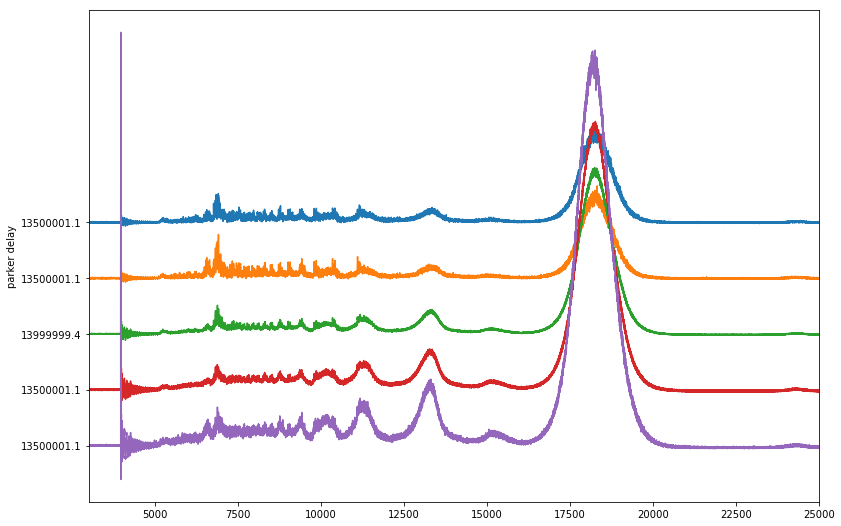

In [9]:
r = [301, 317, 333, 356, 372]
# waterfall=n, where n is the distance between the waterfall plots
# with alpha=0.5, each plot becomes half-tranparent
# groupf is the function providing the data for grouping. If it should be grouped by another value, just copy the function definition of `getdelay`
# above and change the keys accordingly.
fig, ax = plotavg(r, waterfall=30, alpha=1, groupbyf=getdelay)
fig.tight_layout()
fig.set_size_inches((14,8))
fig.savefig('190504 waterfall runs {}.pdf'.format(' '.join([str(n) for n in r])))

# Partial Covariance plot

In [14]:
# dont mess in this cell!
def pcov(data, I=None, corrcoef=False, rowvar=True):
    '''
    Partial covariance
    
    Stephan Kuschel, 2019
    https://gist.github.com/skuschel/9cd745c4b47ad579481b1ade6115250a
    '''
    import numpy as np
    if I is None:
        I = np.mean(data, axis=0 if rowvar else 1)
    I = np.atleast_2d(I)
    c = np.cov(data, I, rowvar=rowvar)
    cov = c[:-1, :-1]
    ret = cov - np.outer(c[-1, :-1], c[:-1, -1]) / c[-1,-1]
    if corrcoef:
        s = np.sqrt(np.diag(ret))
        ret /= np.outer(s,s)
    return ret

def getpcov(runn):
    tof = next(gettof(runn))[:,::2]
    print(tof.shape)
    pc = pcov(tof.T)
    print(pc.shape)
    fig, ax = plt.subplots()
    im = ax.imshow(pc.T, origin='lower', norm=LogNorm(vmin=1e-6))
    addcolorbar(ax, im)
    return fig, ax

## Change here:

(15124, 14000)
(14000, 14000)


<IPython.core.display.Javascript object>


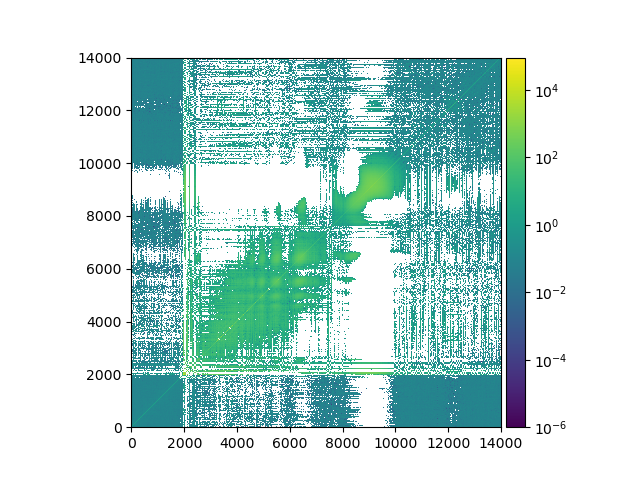

In [15]:
# specify the run you want and maybe save
r = 393
fig, ax = getpcov(r)
fig.savefig('190504 tof pcov r{}.png'.format(r), dpi=600)